# <p style="background-color:#19af6f;font-family:avenir; color:white; text-align:center; font-size:40px; padding:12px; border-radius:20px;"><b>SMS Classifier: Detecting Spam ❌ or Ham ✅</b></p>

# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">IMPORTING LIBRARIES</p>

In [1]:
import re
import nltk
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline    
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

warnings.filterwarnings('ignore')

# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DATA LOADING & EXPLORATION</p>

In [2]:
#Loading data
df = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Dropping the redundent columns & Renaming the columns
df = df.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)
df.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# shape
df.shape

(5572, 2)

In [5]:
# information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
# null data
df.isnull().sum()

Target    0
Text      0
dtype: int64

In [7]:
# duplicate data
df.duplicated().sum()

403

In [8]:
# dropping duplicate data
df.drop_duplicates(inplace=True)

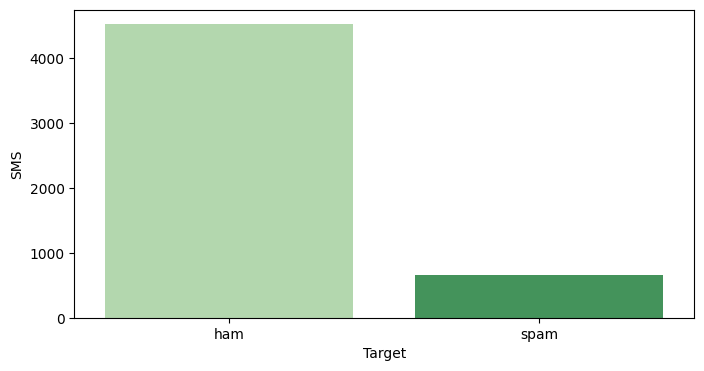

In [9]:
# target feature
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Target', palette='Greens')
plt.xlabel("Target")
plt.ylabel("SMS")
plt.show()

`Note` - Data Is Imbalanced

# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">FEATURE ENGINEERING</p>

In [10]:
"""  
Creating New Features:
1. No of Chars: Number of characters in the text message
2. No of Words: Number of words in the text message
3. No of Sentences: Number of sentences in the text message  
"""

df['No of Chars'] = df['Text'].apply(len)
df['No of Sentences'] = df['Text'].apply(lambda corpus: nltk.sent_tokenize(corpus)).apply(len)
df['No of Words'] = df['Text'].apply(lambda document: nltk.word_tokenize(document)).apply(len)

In [11]:
# data desciption
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No of Chars,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
No of Sentences,5169.0,1.961308,1.432583,1.0,1.0,1.0,2.0,38.0
No of Words,5169.0,18.286129,13.226400,1.0,9.0,15.0,26.0,219.0


# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DETECTING & HANDLING OUTLIERS </p>

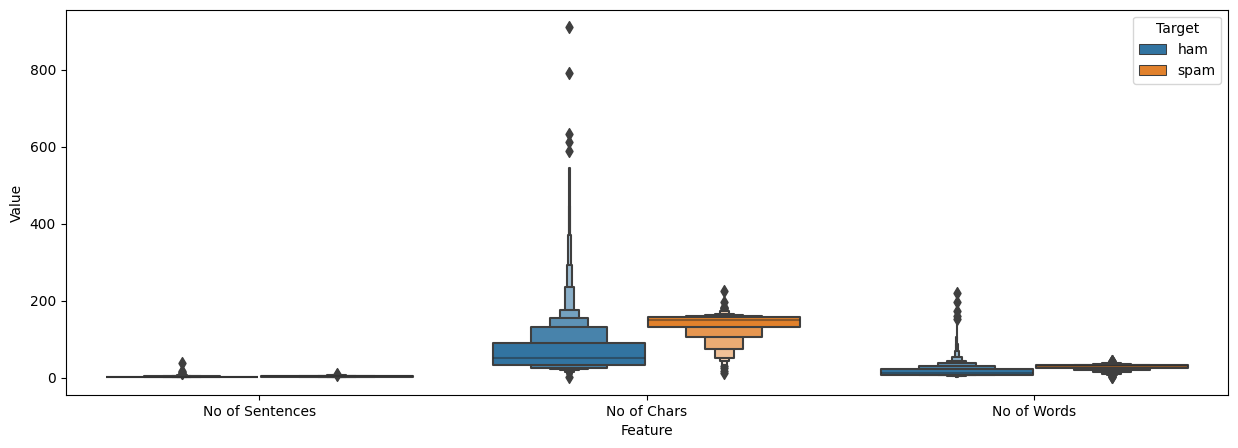

In [12]:
# Plotting Boxplot for outlier detection
melted_df = df.melt(id_vars='Target', value_vars=['No of Sentences', 'No of Chars', 'No of Words'], var_name='Feature', value_name='Value')

plt.figure(figsize=(15,5))
sns.boxenplot(x='Feature', y='Value', data=melted_df, hue='Target')
plt.show()

`Note`: From the above plot, we can clearly see their are few outliers, all in the class ham.

In [13]:
# Identifying Outliers Using IQR
column_name = 'No of Chars'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
outliers.index

Index([  53,  126,  154,  380,  424,  472,  550,  710,  837,  881, 1084, 1359,
       1384, 1512, 1578, 1585, 1826, 1862, 2009, 2011, 2064, 2089, 2133, 2157,
       2355, 2369, 2379, 2407, 2433, 2492, 2502, 2544, 2614, 2855, 2944, 3015,
       3039, 3058, 3105, 3225, 3304, 3349, 3452, 3516, 3564, 3730, 3736, 3777,
       3820, 3878, 4055, 4079, 4289, 4310, 4397, 4407, 4450, 4800, 4865, 4903,
       5003, 5082, 5209, 5451, 5515, 5557],
      dtype='int64')

In [14]:
# Dropping the outliers
df.drop(outliers.index, axis=0, inplace=True)

In [15]:
# Shape after dropping outliers
df.shape

(5103, 5)

# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DATA PRE-PROCESSING</p>

## <p style="background-color:#670eef;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DATA CLEANING</p>

In [ ]:
# Function to clean the data
def data_cleaning(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # replacing all non-alphabetix characters with space
    text = str.lower(text) # lowercasing
    text = text.split()    # splitting string into list
    text = ' '.join(text)  # join all items of the list
    return text


# applying data cleaning and creating new feature  
df['Clean Text'] = df['Text'].apply(data_cleaning)

## <p style="background-color:#670eef;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">TOKENIZATION</p>

In [ ]:
# Applying Word Tokenization & Creating new feature
df['Tokenized Text'] = df['Clean Text'].apply(lambda document: nltk.word_tokenize(document))

## <p style="background-color:#670eef;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">REMOVING STOPWARDS</p>

In [ ]:
# Function to remove stopwords from tokenized text
def stopwords_removal(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokens if word not in stop_words]
    return filtered_text


# applying stopwords removal
df['Filtered Token'] = df['Tokenized Text'].apply(stopwords_removal)

## <p style="background-color:#670eef;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">LEMMATIZATION</p>

`I was getting Error While Performing Lemmatization`: 

Resource 'corpora/wordnet' not found. Please use the NLTK
Downloader to obtain the resource: >>> nltk.download()
Searched in:
- '/root/nltk_data'
- '/usr/share/nltk_data'
- '/usr/local/share/nltk_data'
- '/usr/lib/nltk_data'
- '/usr/local/lib/nltk_data'


`TO solve, run this code`:

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [ ]:
lemmatizer = WordNetLemmatizer()

# Function to lemmatize
def lemmatizing(tokens):
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return lemmas


df['Lemmatized Tokens'] = df['Filtered Token'].apply(lemmatizing)

# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">WORD EMBEDDING | VECTORIZING</p>

In [21]:
# Creating a corpus of Lemmatized Tokens
corpus = []
for tokens in df['Lemmatized Tokens']:
    document = ' '.join([word for word in tokens])
    corpus.append(document)

In [22]:
# Performing Vectorization and creating independent feature
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [23]:
# Encoding Dependent Features
df['Target'] = df['Target'].map({"ham":0, "spam":1})
y = df['Target']

# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">MODEL TRAINING</p>

In [24]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Training on Multiple Classifiers
classifiers = [LogisticRegression(), MultinomialNB(), RandomForestClassifier(), KNeighborsClassifier()]
clf_dict = { 0: "Logistic Regression", 
             1: "NaiveBayes", 
             2: "RandomForest", 
             3: "KNeighbours",}

In [26]:
# Perform Cross Validation
evaluation_results = []

for i, model in enumerate(classifiers):
    # Perform 10-fold cross-validation
    cv_score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Append results to the list
    evaluation_results.append({
        'Model': clf_dict[i],
        'Cross-Validation Accuracy': cv_score.mean(),
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    print(f"{clf_dict[i]}: {round(accuracy*100, 2)}%")

Logistic Regression: 95.98%
NaiveBayes: 97.26%
RandomForest: 97.75%
KNeighbours: 92.16%


# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">MODEL EVALUATION</p>

In [27]:
# Creating DataFrame from the results
evaluation_df = pd.DataFrame(evaluation_results)
metric_category = ['Cross-Validation Accuracy', 'Test Accuracy', 'Precision','Recall', 'F1 Score']
evaluation_df[metric_category] = round(evaluation_df[metric_category]*100, 6)

# Displaying Model Evalutions 
evaluation_df.style.background_gradient(cmap='Greens')

,Model,Cross-Validation Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,95.247255,95.984329,96.002512,95.984329,95.679783
1,NaiveBayes,96.104859,97.257591,97.304671,97.257591,97.110499
2,RandomForest,97.329450,97.747307,97.752934,97.747307,97.662223
3,KNeighbours,90.690949,92.164545,92.599122,92.164545,90.440775


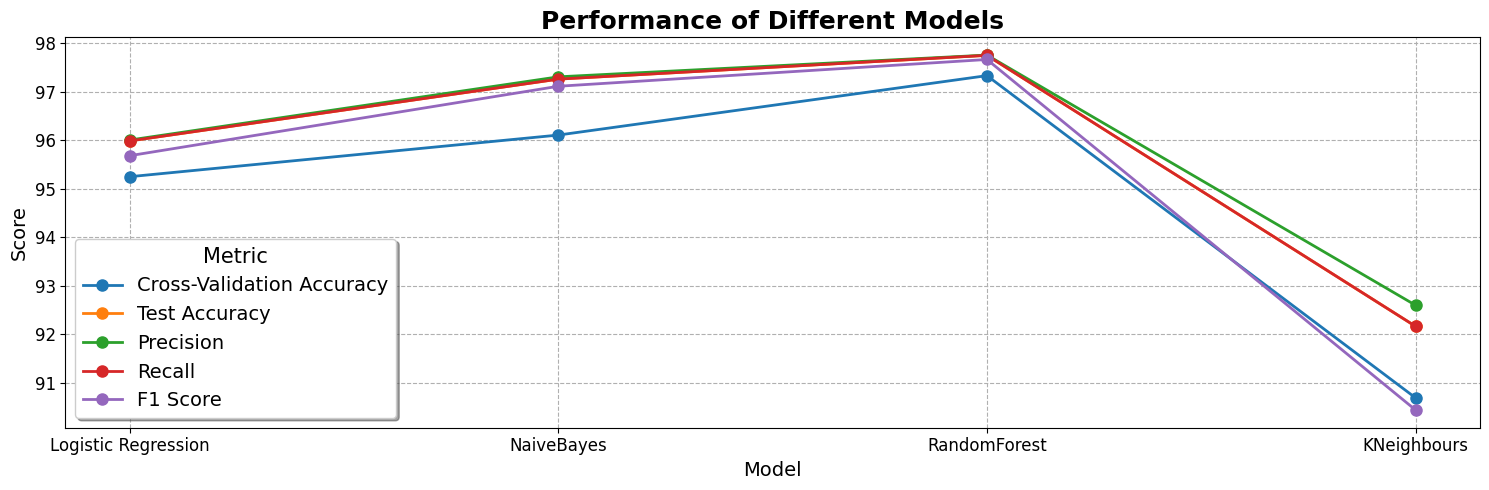

In [28]:
# Plotting Performance of Different Models
plt.figure(figsize=(15, 5))

for i, metric in enumerate(evaluation_df.columns[1:]):
    plt.plot(evaluation_df['Model'], evaluation_df[metric], marker='o', linestyle='-', linewidth=2,  markersize=8, label=metric)

plt.title('Performance of Different Models', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=1)
plt.legend(title='Metric', title_fontsize='15', fontsize='14', loc='best', frameon=True, shadow=True)
plt.tight_layout()  
plt.show()


# <p style="background-color:#21c5a7;font-family:avenir; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;"> <b> THANK YOU! </b>
</p>